In [1]:
from pathlib import Path
from tensorflow.python.keras.callbacks import EarlyStopping
%matplotlib inline
import pandas as pd
from imutils import build_montages
import numpy as np
import cv2
from tqdm.notebook import tqdm
from pprint import pprint
import os

from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda
import keras.backend as K
import matplotlib.pyplot as plt
import skimage
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


# load/preprocess images

In [2]:
DATA_DIR = Path('./frgc32x32/')
images = [x.name for x in DATA_DIR.glob('*')]

In [3]:
image_paths = list(DATA_DIR.glob('*.png'))
user_id = [x.name.split('d')[0] for x in image_paths]
user_img_id = [x.name.split('d')[1].replace('.png', '') for x in image_paths]

directory_df = pd.DataFrame({
    'user_id': user_id,
    'user_img_id': user_img_id,
    'path': [str(x) for x in image_paths]
})

In [4]:
(    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
     .describe()
)

,count
count,568.000000
mean,21.667254
std,16.794857
min,2.000000
25%,8.000000
50%,18.000000
75%,32.000000
max,70.000000


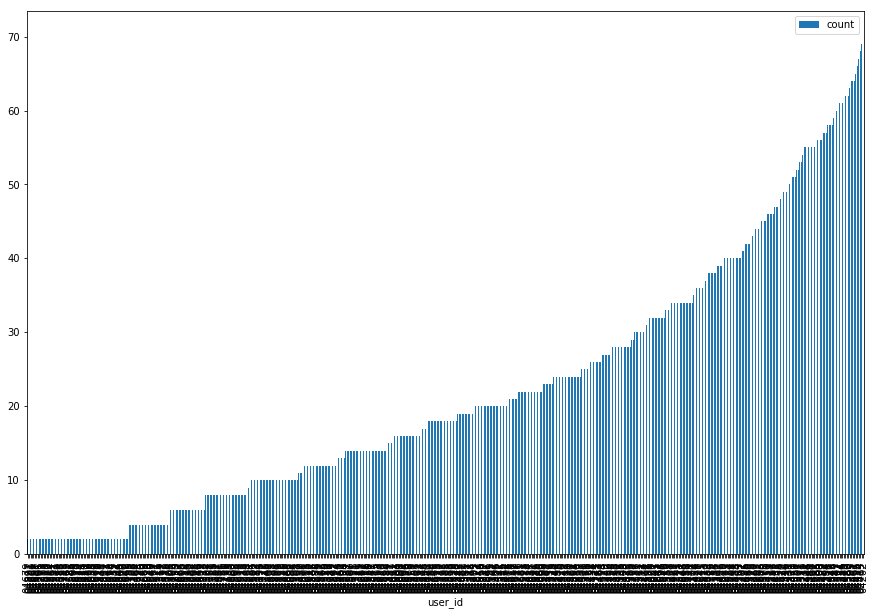

In [5]:
(
    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [6]:
# Get all classes from 10 samples till 60 samples
data_size = 20
class_count_required = 60

ids_testing = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() < data_size
)

ids_to_keep = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() >= data_size
)

ids_to_keep = ids_to_keep[ids_to_keep].index
ids_test = ids_testing[ids_testing].index

subset_directory_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_to_keep)]
    .sample(frac=1)
    .groupby('user_id')
    .head(class_count_required)
    .copy()
)

test_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_test)]
    .sample(frac=1)
    .copy()
)

old_unique = directory_df['user_id'].nunique()
new_unique = subset_directory_df['user_id'].nunique()
print(f"There are {new_unique}/{old_unique} ({new_unique/old_unique*100:.2f}%)" +
      " unique IDs remaining.")

test_unique = test_df['user_id'].nunique()
print(f"There are {test_unique} IDS for testing")

There are 265/568 (46.65%) unique IDs remaining.
There are 303 IDS for testing


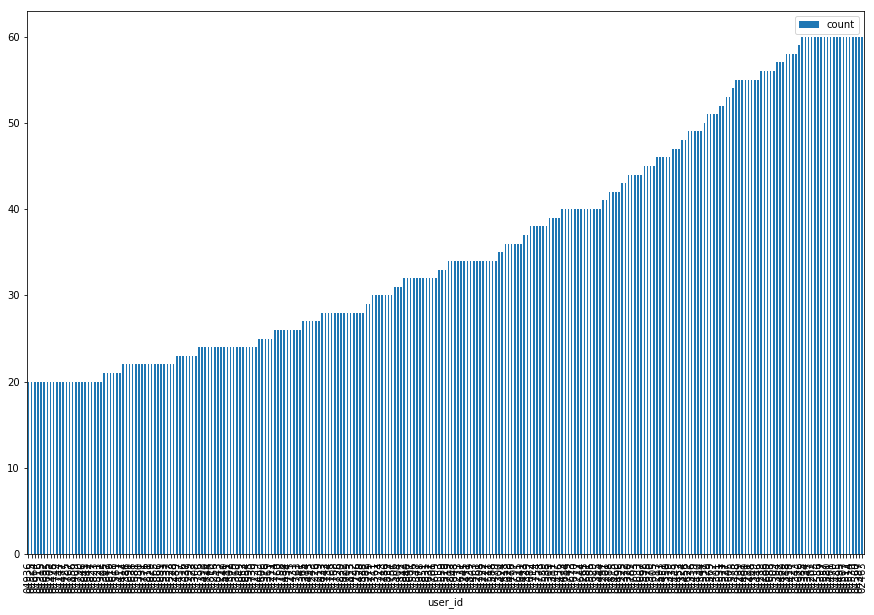

In [7]:
(
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [8]:
counts = (
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .reset_index(drop=False)
    .assign(augmentation_needed=lambda 
            df: class_count_required-df['count'])
)

In [9]:
counts.head()

,user_id,count,augmentation_needed
0,04936,20,40
1,04525,20,40
2,04664,20,40
3,04916,20,40
4,04315,20,40


In [25]:
counts_test = (
    test_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .reset_index(drop=False)
    .assign(augmentation_needed=lambda 
            df: class_count_required-df['count'])
)
counts_test['augmentation_needed'] = 0

In [26]:
counts_test.head()

,user_id,count,augmentation_needed
0,04200,2,0
1,04845,2,0
2,04858,2,0
3,04623,2,0
4,04860,2,0


In [10]:
subset_directory_df.head()
subset_directory_df_sorted = (
    subset_directory_df.sort_values(by=['path'])
)
test_df_sorted = test_df.sort_values(by=['path'])

In [11]:
from imgaug import augmenters as iaa

def augment_image(image):
    # https://github.com/aleju/imgaug
    augmentations = iaa.Sequential([
        iaa.SaltAndPepper(0.03),
    #     iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
    #     iaa.AdditiveLaplaceNoise(scale=(0, 0.03*255)),
    #     iaa.CoarseDropout((0.01, 0.04), size_percent=(0.02, 0.18))
    ])
    seq = augmentations
    return seq(image=image)

In [12]:
from tqdm import tqdm

def read_image(file_path, augment=False):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (32, 32))
    if augment:
        img = augment_image(img)
    return img

In [13]:
def load_images_augment(dataframe, augment_df):
    _labels = []

    items = []
    for _, row in tqdm(augment_df.iterrows(), total=augment_df.shape[0]):
        user_id = row['user_id']
        augmentation_needed = row['augmentation_needed']
        
        _labels.append(user_id)
        lbl = _labels.index(user_id)
        
        relevant_subset = dataframe.loc[dataframe['user_id']==user_id].copy()
        
        for _, row in relevant_subset.iterrows():
            img = read_image(row['path'], augment=False)
            items.append((img, lbl))
            
        if augmentation_needed > relevant_subset.shape[0]:
            items_to_augment = relevant_subset.sample(augmentation_needed, replace=True)    
        else:
            items_to_augment = relevant_subset.sample(augmentation_needed)
        
        for _, row in items_to_augment.iterrows():
            img = read_image(row['path'], augment=True)
            items.append((img, lbl))
    return items

In [15]:
items = load_images_augment(subset_directory_df_sorted, counts)

assert len(items) == counts.shape[0] * class_count_required

100%|██████████| 265/265 [00:09<00:00, 28.21it/s]


In [51]:
test_items = load_images_augment(test_df_sorted, counts_test)

100%|██████████| 303/303 [00:01<00:00, 176.69it/s]


In [53]:
def make_pairs(images, labels, num_classes):
    pairImages = []
    pairLabels = []

    idx = [np.where(labels == i)[0] for i in range(0, num_classes)]

    for idxA in tqdm(range(len(images))):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]

        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]

        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return np.array(pairImages), np.array(pairLabels)

In [59]:
new_unique

265

In [61]:
train_test_split = 0.7
split = int(train_test_split * new_unique) * class_count_required

with open ('identities.txt', 'w+') as f:
    f.write(', '.join([img for img in subset_directory_df_sorted['path'][:split]]) + '\n')
    f.write(', '.join([img for img in subset_directory_df_sorted['path'][split:]]) + '\n')

trainX = np.array([x[0] for x in items[:split]])
trainY = np.array([x[1] for x in items[:split]])

valX = np.array([x[0] for x in items[split:]])
valY = np.array([x[1] for x in items[split:]])

testX = np.array([x[0] for x in test_items])
testY = np.array([x[1] for x in test_items])

trainX = trainX / 255.0
valX = valX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
valX = np.expand_dims(valX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY, num_classes=new_unique)
(pairVal, labelVal) = make_pairs(valX, valY, num_classes=new_unique)
(pairTest, labelTest) = make_pairs(testX, testY, num_classes=test_unique)

100%|██████████| 2759/2759 [00:00<00:00, 47097.28it/s]



# build model

In [72]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 64
EPOCHS = 1

In [64]:
def build_model_20(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(48, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_20')

    return model


In [65]:
def build_model_60(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_60')

    return model

In [66]:
def build_model_130(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(128, (5, 5), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(80, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_130')

    return model

In [67]:
def build_model_250(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(128, (5, 5), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_250')

    return model

In [68]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
    featsA = vectors[0]
    featsB = vectors[1]
	# compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
	# return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [78]:
def train_model(model_fun, save_name, train = True):
    print(f'Training model: {save_name}')

    base_out = 'output'
    model_path = os.path.sep.join([base_out, f'model_{save_name}'])
    plot_path = os.path.sep.join([base_out, f'plot_{save_name}.png'])

    imgA = Input(shape=IMG_SHAPE)
    imgB = Input(shape=IMG_SHAPE)
    featureExtractor = model_fun(IMG_SHAPE)
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)

    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation="sigmoid")(distance)
    model = Model(inputs=[imgA, imgB], outputs=outputs)

    model.compile(loss="binary_crossentropy", optimizer="adam",
	    metrics=["accuracy"])

    print(model.summary())

    if not train:
        return

    history = model.fit(
        [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
        validation_data=([pairVal[:, 0], pairVal[:, 1]], labelVal[:]),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS)

    model.save(model_path)
    plot_training(history, plot_path)
    return model

In [ ]:
train = True
model20 = train_model(build_model_20, 'sn_20', train)
model60 = train_model(build_model_60, 'sn_60', train)
model130 = train_model(build_model_130, 'sn_130', train)
model250 =train_model(build_model_250, 'sn_250', train)

Training model: sn_20
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
model_20 (Model)                (None, 48)           23616       input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 1)            0           model

# Final step: Testing + Comparing our models

In [82]:
model_20_test = model20.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

model_60_test = model60.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

model_130_test = model130.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

model_250_test = model250.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

5518/5518 [==============================] - 2s 425us/step


In [86]:
print(f"Test loss: {model_20_test[0]:.3f} | Test accuracy {model_20_test[1]}")

Test loss: 0.693 | Test accuracy 0.5
